In [150]:
# dir_path = '../data_gen/out'
dir_path = '../data_gen/out_gfh'

In [151]:
import tqdm
import pandas as pd

def convert_time(t):
    if len(t.split('.')) == 1:  # Mikrosekunden fehlen
        t += '.000000'  # Fügen Sie Mikrosekunden hinzu
    return pd.to_datetime(t, format='%H:%M:%S.%f').time()

def convert_time_df(df):
    # df['delta_time'] = df['delta_time'].apply(convert_time)
    df['delta_time'] = [convert_time(item) for item in tqdm.tqdm(df['delta_time'].values, desc='convert time')]
    return df

In [152]:
import os
import tqdm
import pandas as pd

def col_lower_bound(column, col_lower_bound):
    def condition(df):
        # if any entry in the column is higher than col_lower_bound
        return any(df[column] > col_lower_bound)
    return condition

def df_condition(condition, df_transforms=None):
    def condition_func(csv_file_path):
        df = pd.read_csv(csv_file_path)
        if df_transforms:
            for transform in df_transforms:
                df = transform(df)
        return condition(df)
    return condition_func

def filter_files_by_condition(directory, condition, file_type=None):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if not file_type or f.endswith(file_type)]
    filtered_files = [f for f in tqdm.tqdm(files, desc='filter files by condition') if condition(f)]
    return filtered_files

def remove_files(files):
    for f in tqdm.tqdm(files, desc='filter files by condition'):
        os.remove(f)

In [153]:
# import datetime
# import pandas as pd

# dir_path = '../data_gen/out'

# delta_time_lower_bound = pd.to_datetime('0:30:00', format='%H:%M:%S').time()
# df_transforms = [convert_time_df]
# files_high_hour = filter_files_by_condition(dir_path, df_condition(col_lower_bound('delta_time', delta_time_lower_bound), df_transforms), '.csv')
# files_high_hour

In [154]:
# remove_files(files_high_hour)

In [155]:
import re

def get_floats_from_string(input_str):
    if len(input_str) == 0:
        return None
    if len(input_str) == 1:
        return float(input_str)
    if len(input_str) > 1:
        return float(input_str) / (10**(len(input_str)-1))

def parse_string_to_dict(input_str):
    # Verwenden von regulären Ausdrücken, um die erforderlichen Informationen zu extrahieren
    pattern = r"res(_n(\d+))?_p(\d+(\.\d+)?)_dp\((\d+(\.\d+)?_\d+(\.\d+)?_\d+(\.\d+)?)\)_dnp\((\d+(\.\d+)?_\d+(\.\d+)?_\d+(\.\d+)?)\)(_(m))?(_(r))?"

    match = re.match(pattern, input_str)
    if not match:
        return None

    nodes = 0
    if bool(match.group(1)):
        nodes = int(match.group(2))
    percentages = float(get_floats_from_string(match.group(3)))
    dists_present = tuple(get_floats_from_string(val) for val in match.group(5).split('_'))
    dists_present = str(dists_present)
    dists_nonpresent = tuple(get_floats_from_string(val) for val in match.group(9).split('_'))
    dists_nonpresent = str(dists_nonpresent)
    median = bool(match.group(14))
    reciprocal = bool(match.group(16))

    # Erstellen des Dictionarys
    parsed_dict = {
        'nodes': nodes,
        'percentages': percentages,
        'dists_present': dists_present,
        'dists_nonpresent': dists_nonpresent,
        'median': median,
        'reciprocal': reciprocal
    }

    return parsed_dict

# Beispiel-Strings
strings = [
    "res_n5_p01_dp(1_01_1)_dnp(025_01_1)_m_r.csv",
    "res_n5_p06_dp(1_01_1)_dnp(0125_01_1)_r.csv",
    "res_n20_p01_dp(05_01_1)_dnp(025_01_1).csv",
    "res_p01_dp(05_01_1)_dnp(0125_01_1)_part0-100.csv"
]

# Parsen der Beispiel-Strings und Ausgabe der Ergebnisse
for s in strings:
    parsed_result = parse_string_to_dict(s)
    if parsed_result:
        print(parsed_result)
    else:
        print("Ungültiger String:", s)


print(get_floats_from_string('1'))
print(get_floats_from_string('01'))
print(get_floats_from_string('001'))


{'nodes': 5, 'percentages': 0.1, 'dists_present': '(1.0, 0.1, 1.0)', 'dists_nonpresent': '(0.25, 0.1, 1.0)', 'median': True, 'reciprocal': True}
{'nodes': 5, 'percentages': 0.6, 'dists_present': '(1.0, 0.1, 1.0)', 'dists_nonpresent': '(0.125, 0.1, 1.0)', 'median': False, 'reciprocal': True}
{'nodes': 20, 'percentages': 0.1, 'dists_present': '(0.5, 0.1, 1.0)', 'dists_nonpresent': '(0.25, 0.1, 1.0)', 'median': False, 'reciprocal': False}
{'nodes': 0, 'percentages': 0.1, 'dists_present': '(0.5, 0.1, 1.0)', 'dists_nonpresent': '(0.125, 0.1, 1.0)', 'median': False, 'reciprocal': False}
1.0
0.1
0.01


In [156]:
from itertools import product
import json

all_test_combinations = []

with open('../data_gen/tests.json') as f:
    tests = json.load(f)
    nodes = tests['Nodes']

    percentages = tests['Percentages']
    dists_present = [str(tuple(float(n) for n in eval(x))) for x in tests['Distributions']['present']]
    dists_nonpresent = [str(tuple(float(n) for n in eval(x))) for x in tests['Distributions']['nonpresent']]
    median = [bool(x) for x in tests['Median']]
    reciprocal = [bool(x) for x in tests['Reciprocal']]

    all_test_combinations = list(
        dict(zip(['nodes', 'percentages', 'dists_present', 'dists_nonpresent', 'median', 'reciprocal'], l))
        for l in product(nodes, percentages, dists_present, dists_nonpresent, median, reciprocal))

len(all_test_combinations), all_test_combinations[0]


(4032,
 {'nodes': 5,
  'percentages': 0.1,
  'dists_present': '(0.5, 0.1, 1.0)',
  'dists_nonpresent': '(0.125, 0.1, 1.0)',
  'median': False,
  'reciprocal': False})

In [157]:
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
csv_files_meta_infos = [parse_string_to_dict(f) for f in csv_files]
len(csv_files_meta_infos), csv_files_meta_infos[0]

(880,
 {'nodes': 0,
  'percentages': 0.1,
  'dists_present': '(0.5, 0.1, 1.0)',
  'dists_nonpresent': '(0.125, 0.1, 1.0)',
  'median': True,
  'reciprocal': False})

In [158]:
failed_test_settings = [t for t in all_test_combinations if t not in csv_files_meta_infos]
len(failed_test_settings), failed_test_settings[0] if len(failed_test_settings) > 0 else None

(4032,
 {'nodes': 5,
  'percentages': 0.1,
  'dists_present': '(0.5, 0.1, 1.0)',
  'dists_nonpresent': '(0.125, 0.1, 1.0)',
  'median': False,
  'reciprocal': False})

In [159]:
import os
import pandas as pd
import tqdm

def concat_csv_files_in_directory(directory):
    # Liste alle Dateien im Verzeichnis mit der Endung ".csv" auf
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    print("Found {} CSV files in directory '{}'.".format(len(csv_files), directory))
    
    # Überprüfe, ob mindestens eine CSV-Datei gefunden wurde
    if not csv_files:
        print("Keine CSV-Dateien im Verzeichnis gefunden.")
        return None
    
    # Initialisiere ein leeres DataFrame, um die Daten zu speichern
    combined_df = pd.DataFrame()
    
    # Durchlaufe die CSV-Dateien und lese sie in das DataFrame ein
    for csv_file in tqdm.tqdm(csv_files, total=len(csv_files), desc="load csv files"):
        file_path = os.path.join(directory, csv_file)
        df = pd.read_csv(file_path)

        # add metadata to dataframe
        metadata = parse_string_to_dict(csv_file)
        for key, value in metadata.items():
            df[key] = [value]*len(df)
        
        # Füge das gelesene DataFrame dem kombinierten DataFrame hinzu
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df

In [160]:
# dir_path = '../data_gen/out'
df = concat_csv_files_in_directory(dir_path)
df

Found 880 CSV files in directory '../data_gen/out_gfh'.


load csv files: 100%|██████████| 880/880 [00:32<00:00, 27.49it/s]


,delta_time,symmetric_difference,nodes,rel_size,success,tree,alg,percentages,dists_present,dists_nonpresent,median,reciprocal
0,0:00:00.006967,0.000000,0,66,True,113885961301,Alg1,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
1,0:00:00.140191,0.000000,0,66,True,113885961301,Alg2,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
2,0:00:00.045690,0.533333,0,66,True,113885961301,Alg2_normal,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
3,0:00:00.173118,0.600000,0,66,True,113885961301,Louvain,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
4,0:00:00.010996,0.600000,0,66,True,113885961301,Greedy Sum,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
703995,0:00:00.226708,0.200000,0,81,True,127103818525,Louvain,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703996,0:00:00.028524,0.200000,0,81,True,127103818525,Greedy Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703997,0:00:00.027999,0.200000,0,81,True,127103818525,Greedy Average,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703998,0:00:00.018001,0.200000,0,81,True,127103818525,Random Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False


In [161]:
del df['tree']
df

,delta_time,symmetric_difference,nodes,rel_size,success,alg,percentages,dists_present,dists_nonpresent,median,reciprocal
0,0:00:00.006967,0.000000,0,66,True,Alg1,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
1,0:00:00.140191,0.000000,0,66,True,Alg2,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
2,0:00:00.045690,0.533333,0,66,True,Alg2_normal,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
3,0:00:00.173118,0.600000,0,66,True,Louvain,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
4,0:00:00.010996,0.600000,0,66,True,Greedy Sum,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
...,...,...,...,...,...,...,...,...,...,...,...
703995,0:00:00.226708,0.200000,0,81,True,Louvain,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703996,0:00:00.028524,0.200000,0,81,True,Greedy Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703997,0:00:00.027999,0.200000,0,81,True,Greedy Average,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703998,0:00:00.018001,0.200000,0,81,True,Random Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False


In [162]:
df = convert_time_df(df)
df

convert time:   7%|▋         | 48813/704000 [1:02:10<53:19, 204.76it/s]   

convert time: 100%|██████████| 704000/704000 [1:02:59<00:00, 186.28it/s]  


,delta_time,symmetric_difference,nodes,rel_size,success,alg,percentages,dists_present,dists_nonpresent,median,reciprocal
0,00:00:00.006967,0.000000,0,66,True,Alg1,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
1,00:00:00.140191,0.000000,0,66,True,Alg2,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
2,00:00:00.045690,0.533333,0,66,True,Alg2_normal,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
3,00:00:00.173118,0.600000,0,66,True,Louvain,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
4,00:00:00.010996,0.600000,0,66,True,Greedy Sum,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
...,...,...,...,...,...,...,...,...,...,...,...
703995,00:00:00.226708,0.200000,0,81,True,Louvain,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703996,00:00:00.028524,0.200000,0,81,True,Greedy Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703997,00:00:00.027999,0.200000,0,81,True,Greedy Average,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703998,00:00:00.018001,0.200000,0,81,True,Random Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False


In [163]:
import datetime

def time_to_units(time_obj, time_unit):
    """ Konvertiert ein datetime.time-Objekt in die gewählte Zeiteinheit. """
    if time_unit == 'seconds':
        return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    elif time_unit == 'minutes':
        return time_obj.hour * 60 + time_obj.minute + time_obj.second / 60
    elif time_unit == 'hours':
        return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600
    elif time_unit == 'milliseconds':
        return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000 + time_obj.microsecond / 1000
    elif time_unit == 'microseconds':
        return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000000 + time_obj.microsecond

def determine_time_unit(column):
    """ Bestimmt die passende Zeiteinheit basierend auf dem Bereich der Werte in der Spalte. """
    # total_seconds = column.apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6)
    # max_time = total_seconds.max()
    # min_time = total_seconds.min()

    # if max_time - min_time < 60:  # Bereich ist weniger als 1 Minute
    #     if max_time - min_time < 1:  # Bereich ist weniger als 1 Sekunde
    #         return 'milliseconds' if max_time < 1 else 'seconds'
    #     return 'seconds'
    # elif max_time - min_time < 3600:  # Bereich ist weniger als 1 Stunde
    #     return 'minutes'
    # else:
    #     return 'hours'

    return 'seconds'
    

def to_num_df(dataframe):
    # Umwandeln von datetime.time Spalten in numerische Werte
    num_dataframe = dataframe.copy()
    for col in num_dataframe.columns.copy():
        if isinstance(num_dataframe[col].iloc[0], datetime.time):
            time_unit = determine_time_unit(num_dataframe[col])
            num_dataframe[col] = num_dataframe[col].apply(lambda t: time_to_units(t, time_unit))
            num_dataframe = num_dataframe.rename(columns={col: f'{col}_{time_unit}'})

    return num_dataframe

In [164]:
df = to_num_df(df)
df

,delta_time_seconds,symmetric_difference,nodes,rel_size,success,alg,percentages,dists_present,dists_nonpresent,median,reciprocal
0,0,0.000000,0,66,True,Alg1,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
1,0,0.000000,0,66,True,Alg2,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
2,0,0.533333,0,66,True,Alg2_normal,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
3,0,0.600000,0,66,True,Louvain,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
4,0,0.600000,0,66,True,Greedy Sum,0.1,"(0.5, 0.1, 1.0)","(0.125, 0.1, 1.0)",True,False
...,...,...,...,...,...,...,...,...,...,...,...
703995,0,0.200000,0,81,True,Louvain,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703996,0,0.200000,0,81,True,Greedy Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703997,0,0.200000,0,81,True,Greedy Average,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False
703998,0,0.200000,0,81,True,Random Sum,0.9,"(1.0, 0.1, 1.0)","(0.125, 0.1, 1.0)",False,False


In [165]:
import matplotlib.pyplot as plt
import numpy as np

def scatterplot_matrix(dataframe, color_column=None, subplot_size=2.5, subplot_spacing=0.05):
    n_vars = dataframe.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars * subplot_size, n_vars * subplot_size))

    # num_dataframe = to_num_df(dataframe)
    num_dataframe = dataframe
            
    # Farbkodierung einrichten
    if color_column is not None and color_column in num_dataframe.columns:
        unique_values = num_dataframe[color_column].unique()
        colormap = plt.cm.get_cmap('viridis', len(unique_values))
        color_dict = {val: colormap(i) for i, val in enumerate(unique_values)}
        colors = num_dataframe[color_column].map(color_dict)
    else:
        colors = 'b'

    # Erstellen der Scatterplots
    bar = tqdm.tqdm(total=n_vars**2, desc='draw subplots')
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            if i == j:
                ax.text(0.5, 0.5, num_dataframe.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.scatter(num_dataframe.iloc[:, j], num_dataframe.iloc[:, i], c=colors)

            # Setzen der Ticklabels
            if i != n_vars - 1:
                ax.set_xticklabels([])
            if j != 0:
                ax.set_yticklabels([])

            # Setzen der Achsenbeschriftungen
            if j == 0:
                ax.set_ylabel(num_dataframe.columns[i])
            if i == n_vars - 1:
                ax.set_xlabel(num_dataframe.columns[j])

            bar.update(1)

    # Anpassen der Abstände zwischen den Subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=subplot_spacing, hspace=subplot_spacing)

    plt.show()

In [166]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from matplotlib.ticker import MaxNLocator

def plot_distribution(dataframe, color_column=None, max_xticks=10, subplot_width=2.5, subplot_hight=2, subplot_spacing=0.05):
    n_vars = dataframe.shape[1]
    
    if color_column is not None:
        unique_values = dataframe[color_column].unique()
        num_colors = len(unique_values)
    else:
        unique_values = [None]
        num_colors = 1
    colormap = plt.cm.get_cmap('viridis', len(unique_values))
    color_dict = {val: colormap(i) for i, val in enumerate(unique_values)}
    
    fig, axes = plt.subplots(n_vars, num_colors, figsize=(subplot_width * num_colors, subplot_hight * n_vars))
    
    # Kopieren des DataFrames zur Umwandlung von datetime.time in numerische Werte
    num_dataframe = dataframe.copy()
    for col in num_dataframe.columns.copy():
        if isinstance(num_dataframe[col].iloc[0], datetime.time):
            time_unit = determine_time_unit(num_dataframe[col])
            num_dataframe[col] = num_dataframe[col].apply(lambda t: time_to_units(t, time_unit))
            num_dataframe = num_dataframe.rename(columns={col: f'{col}_{time_unit}'})

        if num_dataframe[col].dtype == bool:
            num_dataframe[col] = num_dataframe[col].astype(int)

    bar = tqdm.tqdm(total=len(unique_values)*len(num_dataframe.columns), desc='draw subplots')
    for i, unique_value in enumerate(unique_values):
        for j, column in enumerate(num_dataframe.columns):
            # print(f'{unique_value=}, {column=}')

            if len(unique_values) == 1:
                ax = axes[j]
            else:
                ax = axes[j, i]  # Vertauschte Indizes für das gewünschte Layout
            
            if color_column is not None:
                data = num_dataframe[num_dataframe[color_column] == unique_value][column]
                # print(f'{data=}')
                # ax.hist(data, bins=20, edgecolor='black', label=f'{color_column}: {unique_value}', color=color_dict[unique_value])  # Ändere die Farbe hier
                ax.hist(data, bins=20, edgecolor='black', color=color_dict[unique_value])  # Ändere die Farbe hier
                # if j == len(unique_values) -1:
                    # ax.set_xlabel(unique_value)
                # ax.xaxis.set_major_locator(MaxNLocator(max_xticks))
                if i == 0:  # Beschrifte nur die linken Achsen
                    ax.set_ylabel(column)
                else:
                    ax.set_yticklabels([])
                # ax.legend()
            else:
                ax.hist(num_dataframe[column], bins=20, edgecolor='black')
                ax.set_xlabel(column)
                ax.xaxis.set_major_locator(MaxNLocator(max_xticks))
                if i == 0:  # Beschrifte nur die linken Achsen
                    ax.set_ylabel(column)
                else:
                    ax.set_yticklabels([])

            bar.update(1)
    
    for i, unique_value in enumerate(unique_values):
        if color_column is not None:
            axes[0, i].set_title(f'{color_column}: {unique_value}')
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=subplot_spacing, hspace=subplot_spacing)

    # plt.tight_layout()
    plt.show()


In [167]:
# import matplotlib.pyplot as plt

# # Annahme: Ihr DataFrame heißt 'df' und Sie möchten das Histogramm für die Spalte 'column_name' erstellen
# column_name = 'rel_size'

# # Erstellen Sie das Histogramm
# plt.hist(df[column_name], bins=10, edgecolor='black')  # Anzahl der Bins anpassen, wenn nötig
# plt.xlabel(column_name)
# plt.ylabel('Häufigkeit')
# plt.title(f'Histogramm für {column_name}')
# plt.show()


In [168]:
def plot_box(df, x, y, figsize=(8, 6)):
    df_copy = df.copy()
    df_copy[x] = pd.Categorical(df_copy[x])

    # Erstellen Sie ein Boxplot
    plt.figure(figsize=figsize)  # Optional: Legen Sie die Größe des Plots fest

    plt.boxplot([group[y] for name, group in df_copy.groupby(x)], labels=df_copy[x].cat.categories)

    plt.title(f'Boxplot nach {x}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_box_with_subplots(df, x, y, z, subplot_size=(6, 4)):
    df_copy = df.copy()
    df_copy[x] = pd.Categorical(df_copy[x])

    if z is not None:
        df_copy[z] = pd.Categorical(df_copy[z])

    unique_categories_x = df_copy[x].cat.categories

    unique_categories_z = df_copy[z].cat.categories

    num_plots = len(unique_categories_z)
    # num_cols = 1 if z is None else len(unique_categories_z)

    # plt.figure(figsize=figsize)

    fig, axes = plt.subplots(num_plots, figsize=(subplot_size[0], num_plots * subplot_size[1]))

    for i, category_z in enumerate(unique_categories_z):
        ax = axes[i]

        subset = df_copy[df_copy[z] == category_z]
        subset_copy = subset.copy()
        subset_copy[x] = pd.Categorical(subset_copy[x])

        ax.boxplot([group[y] for name, group in subset_copy.groupby(x)], labels=df_copy[x].cat.categories)
        ax.set_title(f'Boxplot für {z}={category_z}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)

    plt.tight_layout()
    plt.show()


In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_3d(df, val, x, y, figsize=(8, 6), aggfunc='mean'):
    # Pivot-Tabelle erstellen, um den Durchschnitt der Werte pro Kategorie zu erhalten
    pivot_table = df.pivot_table(values=val, index=y, columns=x, aggfunc=aggfunc)

    # Heatmap erstellen
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".3f", linewidths=.5)
    plt.title(f'Heatmap {str(aggfunc)} on {val}')
    plt.show()

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_correlation_matrix(df):
    # Erstellen der Kovarianzmatrix
    cov_matrix = df.cov()
    # Berechnen Sie die Standardabweichungen
    std_dev = df.std()
    # Erstellen Sie die Korrelationsmatrix
    correlation_matrix = cov_matrix / (std_dev.values.reshape(-1, 1) * std_dev.values)
    return correlation_matrix

def plot_correlation_matrix(df, figsize=(8, 6)):
    correlation_matrix = get_correlation_matrix(df)
    
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".3f", linewidths=.5)
    plt.title(f'Heatmap correlation_matrix')
    plt.show()

In [172]:
import numpy as np
import math

def abs_sum_metric(correlation_matrix):
    return np.sum(np.abs(correlation_matrix.fillna(math.inf).values))

def correlation_search(df, search_col, col_subset=None):
    unique_values = df[search_col].unique()

    best_value = None
    best_metric = None
    best_correlation_matrix = None

    for val in unique_values:
        df_filtered = df[df[search_col] == val]
        if col_subset is not None:
            df_filtered = df_filtered[col_subset]
        correlation_matrix = get_correlation_matrix(df_filtered)
        metric = abs_sum_metric(correlation_matrix)

        if best_metric is None or metric < best_metric:
            best_metric = metric
            best_value = val
            best_correlation_matrix = correlation_matrix

    return best_value, best_metric, best_correlation_matrix


In [173]:
# # col_subset = ['delta_time_seconds', 'symmetric_difference', 'nodes', 'rel_size', 'percentages', 'median', 'reciprocal']
# col_subset = ['delta_time_seconds', 'symmetric_difference', 'rel_size', 'percentages', 'median', 'reciprocal']
# best_value, best_metric, best_correlation_matrix = correlation_search(df, 'alg', col_subset)
# print(f'{best_value=}, {best_metric=}')
# plt.figure(figsize=(8,6))
# sns.heatmap(best_correlation_matrix, annot=True, cmap='YlGnBu', fmt=".3f", linewidths=.5)
# plt.title(f'Heatmap correlation_matrix')
# plt.show()

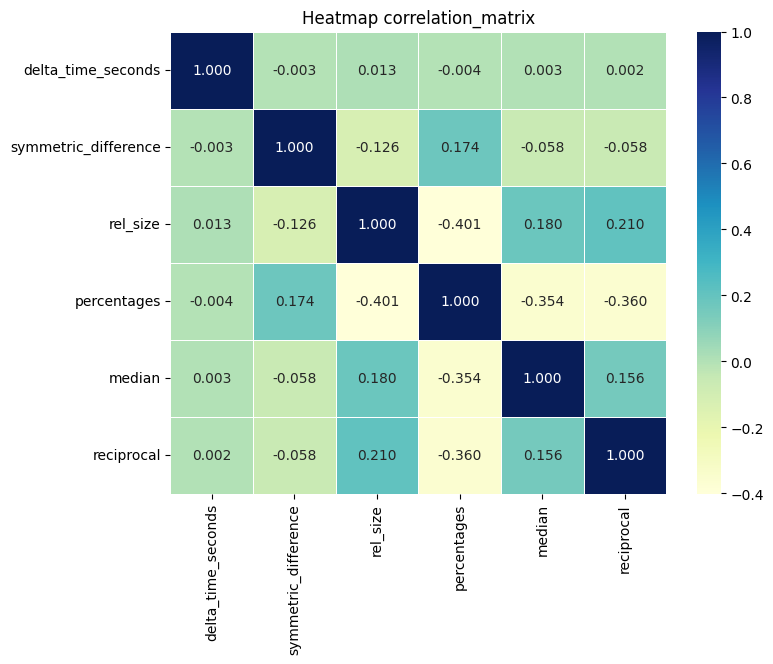

In [174]:
# df_filtered = df[df['nodes'] == 20]
df_filtered = df
# df_subset = df_filtered[['delta_time_seconds', 'symmetric_difference', 'nodes', 'rel_size', 'percentages', 'median', 'reciprocal']]
df_subset = df_filtered[['delta_time_seconds', 'symmetric_difference', 'rel_size', 'percentages', 'median', 'reciprocal']]
plot_correlation_matrix(df_subset)

In [175]:
# scatterplot_matrix(df, color_column='alg')

C:\Users\Max\AppData\Local\Temp\ipykernel_8436\788508310.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', len(unique_values))
draw subplots:   0%|          | 0/3 [00:00<?, ?it/s]

draw subplots:  67%|██████▋   | 2/3 [00:00<00:00, 12.69it/s]

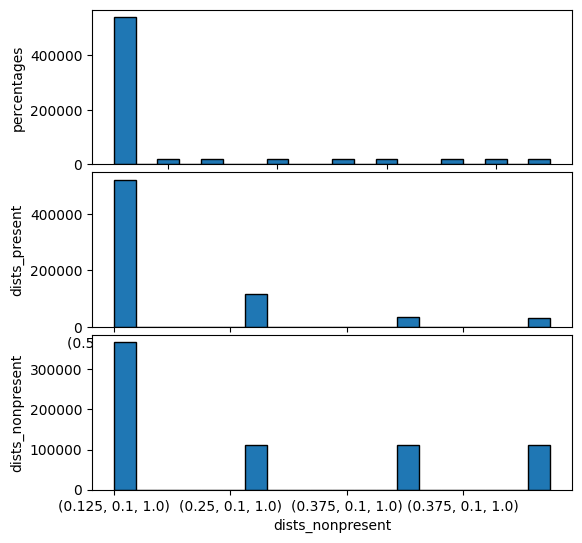

draw subplots: 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


In [176]:
# plot_distribution(df, color_column='alg', max_xticks=5, subplot_spacing=0.05)
plot_distribution(df[['percentages', 'dists_present', 'dists_nonpresent']], max_xticks=5, subplot_spacing=0.05, subplot_width=6)
# plot_distribution(df, max_xticks=5)

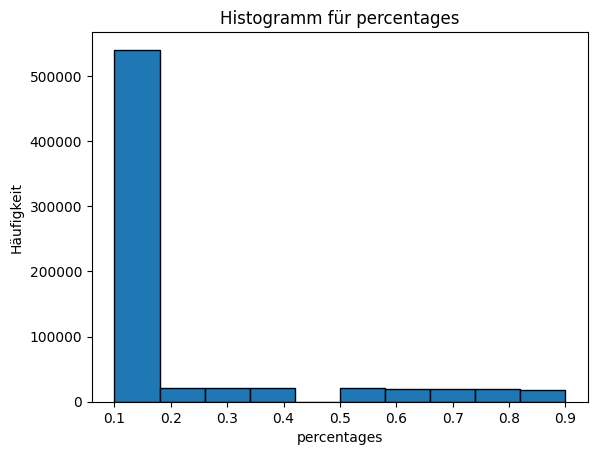

In [177]:
import matplotlib.pyplot as plt

# Annahme: Ihr DataFrame heißt 'df' und Sie möchten das Histogramm für die Spalte 'column_name' erstellen
column_name = 'percentages'

# Erstellen Sie das Histogramm
plt.hist(df[column_name], bins=10, edgecolor='black')  # Anzahl der Bins anpassen, wenn nötig
plt.xlabel(column_name)
plt.ylabel('Häufigkeit')
plt.title(f'Histogramm für {column_name}')
plt.show()


C:\Users\Max\AppData\Local\Temp\ipykernel_8436\2592770338.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.boxplot([group[y] for name, group in df_copy.groupby(x)], labels=df_copy[x].cat.categories)


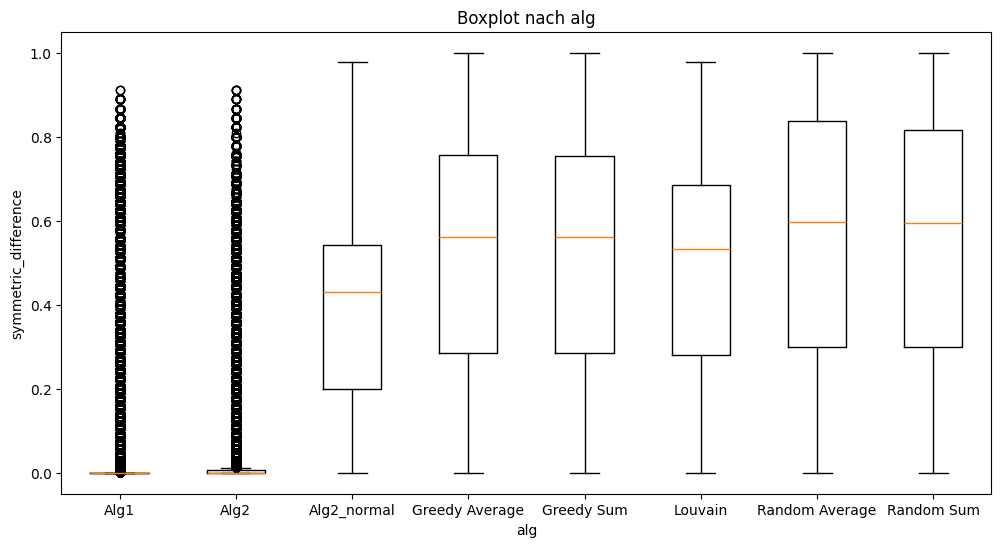

In [178]:
plot_box(df, 'alg', 'symmetric_difference', figsize=(12, 6))

C:\Users\Max\AppData\Local\Temp\ipykernel_8436\2592770338.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.boxplot([group[y] for name, group in df_copy.groupby(x)], labels=df_copy[x].cat.categories)


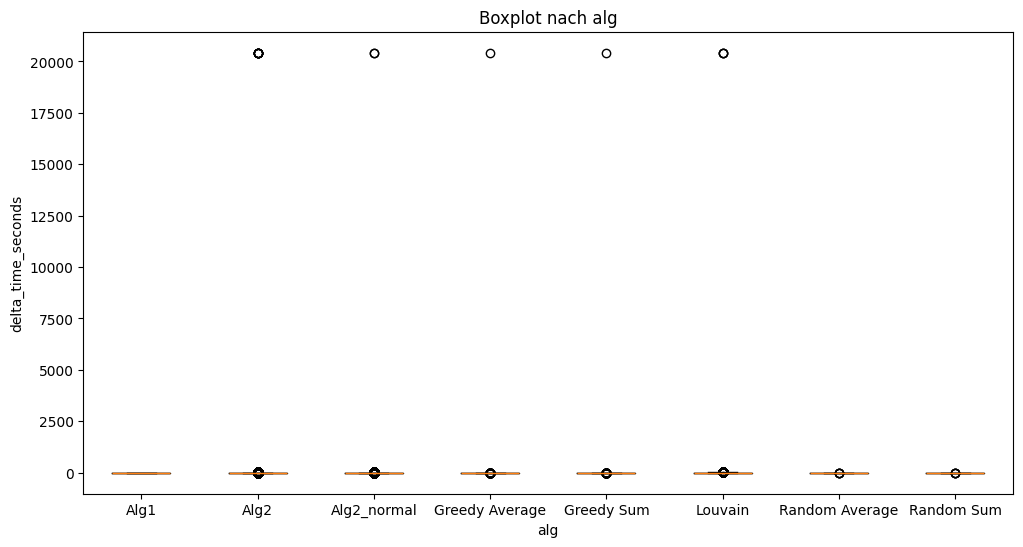

In [179]:
plot_box(df, 'alg', 'delta_time_seconds', figsize=(12, 6))

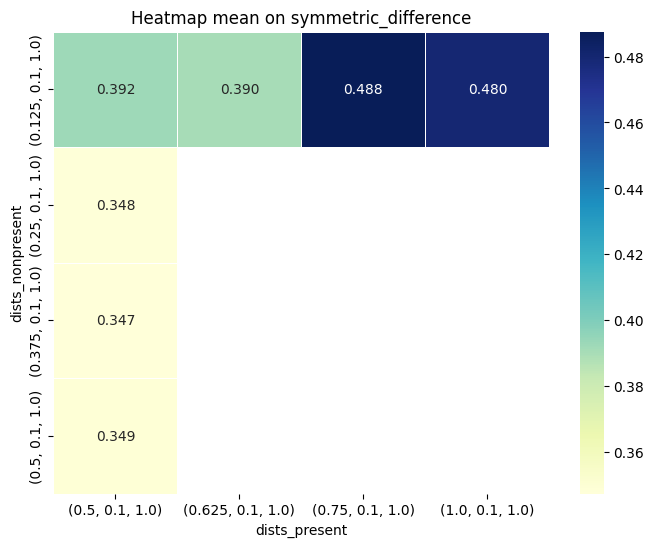

In [191]:
# heatmap_3d(df[(df['alg']=='Alg2_normal') & (df['percentages']==0.9)], 'symmetric_difference', 'dists_present', 'dists_nonpresent', figsize=(8, 6))
heatmap_3d(df[(df['alg']=='Alg2_normal')], 'symmetric_difference', 'dists_present', 'dists_nonpresent', figsize=(8, 6))
# heatmap_3d(df[(df['alg']=='Louvain')], 'symmetric_difference', 'dists_present', 'dists_nonpresent', figsize=(8, 6))

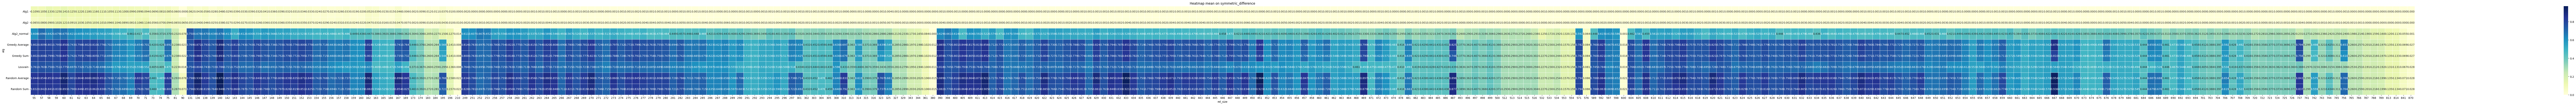

In [189]:
# heatmap_3d(df, 'symmetric_difference', 'nodes', 'alg', figsize=(8, 6))
heatmap_3d(df, 'symmetric_difference', 'rel_size', 'alg', figsize=(200, 6))

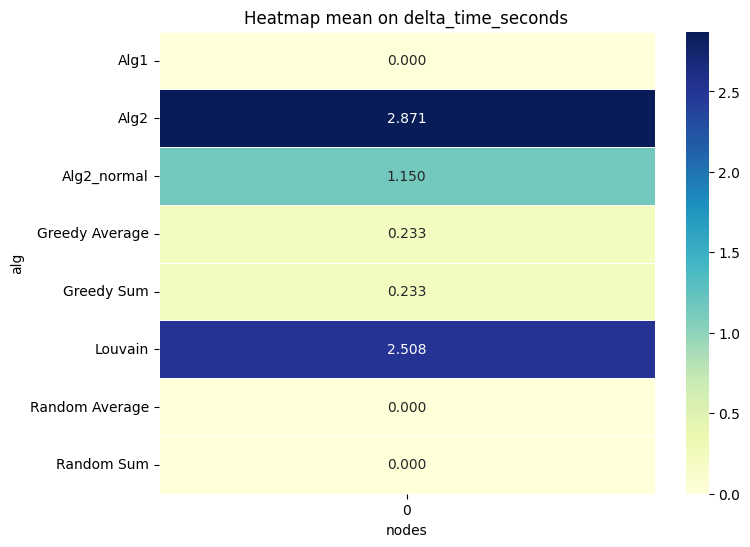

In [182]:
heatmap_3d(df, 'delta_time_seconds', 'nodes', 'alg', figsize=(8, 6))

C:\Users\Max\AppData\Local\Temp\ipykernel_8436\2942394958.py:7: FutureWarning: The provided callable <function var at 0x000001E258AF7240> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  pivot_table = df.pivot_table(values=val, index=y, columns=x, aggfunc=aggfunc)


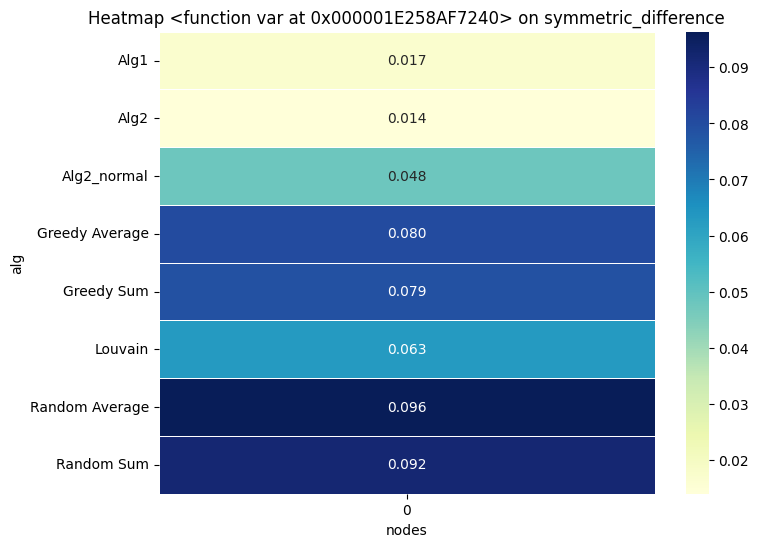

In [183]:
import numpy as np
heatmap_3d(df, 'symmetric_difference', 'nodes', 'alg', figsize=(8, 6), aggfunc=np.var)
# heatmap_3d(df, 'symmetric_difference', 'rel_size', 'alg', figsize=(100, 6), aggfunc=np.var)

C:\Users\Max\AppData\Local\Temp\ipykernel_8436\1822037677.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax.boxplot([group[y] for name, group in subset_copy.groupby(x)], labels=df_copy[x].cat.categories)
C:\Users\Max\AppData\Local\Temp\ipykernel_8436\1822037677.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax.boxplot([group[y] for name, group in subset_copy.groupby(x)], labels=df_copy[x].cat.categories)
C:\Users\Max\AppData\Local\Temp\ipykernel_8436\1822037677.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

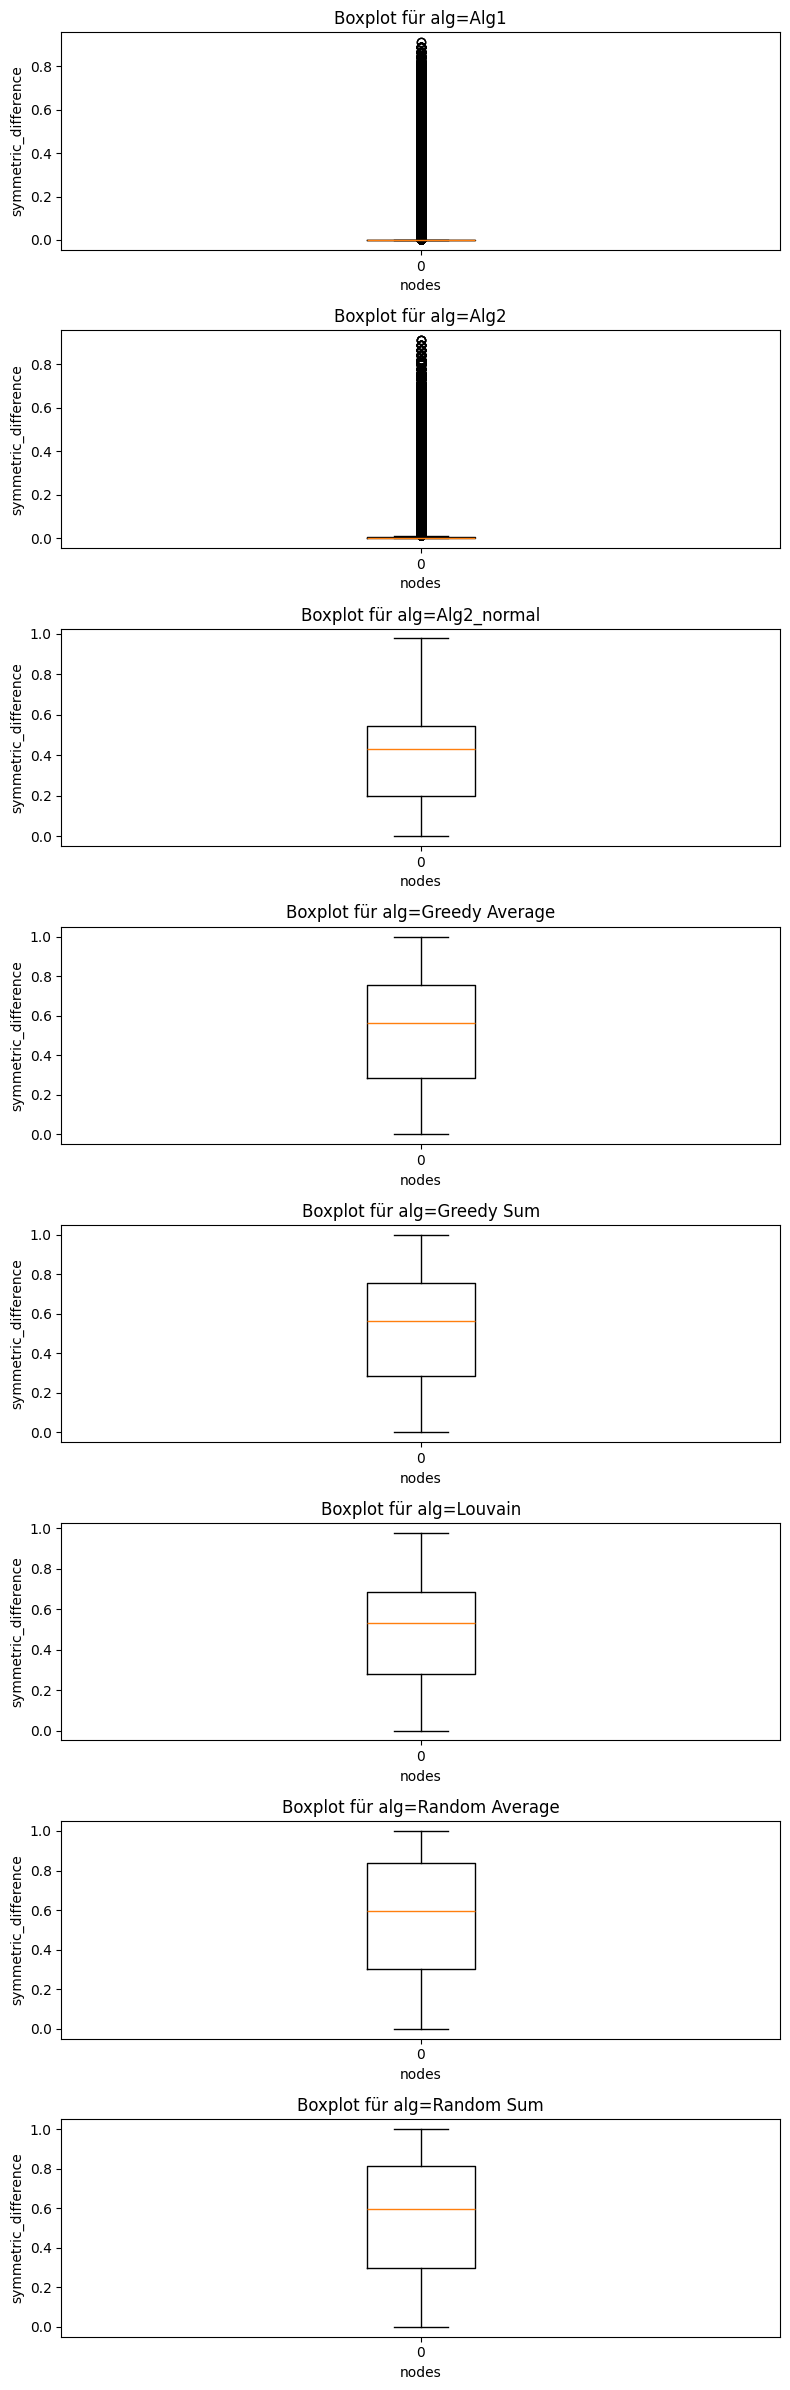

In [184]:
plot_box_with_subplots(df, 'nodes', 'symmetric_difference', 'alg', subplot_size=(8, 3))
# plot_box_with_subplots(df, 'rel_size', 'symmetric_difference', 'alg', subplot_size=(100, 3))

In [185]:
# # todos
# baum params mit aufnehmen und vergleichen, wie parcial prozent
# boxplots für symmetric differences

In [186]:
# boxplot alg vs. symmetric_difference
# boxplot alg vs. delta_time

# für jeden alg mtx mit farbigen pixeln für symmetric_difference mean, x: dist_present, y: dist_nonpresent

# scatterplot_matrix als boxplot mtx für cat columns

# bonus:
# alg vs. rel_size vs. symmetric_difference

# Spannend wäre dann natürlich zusehen für welche Parameter das failt
# Auch spannend wäre zu sehen ob in jeder file genau Anzahl Bäume * Anzahl Algs einträge sind
# plot mit den verteilungen von percentages
# plot verteilung von nodes

# präse - aufbau

## baum automaten

## unser louvain
### wie 2 partitionen enforced
- kein cutoff
- gewicht gewählt, so dass 2 partitions
- min statt max

## versuchsaufbau
test.json

## ergebnisse
